In [33]:
import pandas as pd
import mlflow 
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("my_regression_experiment")


2022/05/25 20:27:13 INFO mlflow.tracking.fluent: Experiment with name 'my_regression_experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='my_regression_experiment', tags={}>

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [3]:
categorical=['PUlocationID','DOlocationID']
    

In [4]:
def read_dataframe(file_name):
    df = pd.read_parquet(file_name, engine='pyarrow')
    df.pickup_datetime = pd.to_datetime(df.pickup_datetime)
    df.dropOff_datetime = pd.to_datetime(df.dropOff_datetime)
    df['duration'] = df.dropOff_datetime - df.pickup_datetime
    df.duration = df.duration.apply(lambda x: x.total_seconds()/60)
    df=df.fillna(-1)
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    categorical=['PUlocationID','DOlocationID']
    df[categorical]=df[categorical].astype(str)
    return df
# df=df[(df.)]



In [5]:
train_df=read_dataframe('../data/fhv_tripdata_2021-01.parquet')
val_df=read_dataframe('../data/fhv_tripdata_2021-02.parquet')

In [6]:

train_df.duration.mean()

16.2472533682457

In [7]:
(len(train_df[train_df['PUlocationID']==-1].any(axis=1)) /len(train_df))* 100

0.0

c:\Users\haddi\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\haddi\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
c:\Users\haddi\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
c:\User

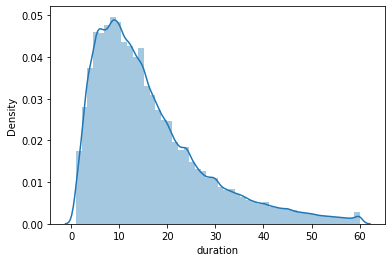

In [8]:
sns.distplot(train_df.duration)

In [9]:
train_df.duration.describe(percentiles=[0.95,0.98,0.99])

count    1.109826e+06
mean     1.624725e+01
std      1.155150e+01
min      1.000000e+00
50%      1.323333e+01
95%      4.070000e+01
98%      4.936667e+01
99%      5.423333e+01
max      6.000000e+01
Name: duration, dtype: float64

In [10]:
train_dicts=train_df[categorical].to_dict('records')

In [43]:
dv=DictVectorizer()
X_train=dv.fit_transform(train_dicts)
X_val=dv.transform(val_df[categorical].to_dict('records'))


In [12]:
target='duration'
y_train=train_df[target].values
    

In [13]:

y_val=val_df[target].values
    

In [14]:
lr=LinearRegression()
lr.fit(X_train,y_train)


LinearRegression()

In [34]:
with mlflow.start_run():
    alpha=0.001
    mlflow.set_tag("model_name", "Linear Regression")
    mlflow.set_tag("Author", "Hadi")
    mlflow.log_param("alpha", alpha)
    mlflow.log_param('Train_data_path', '../data/fhv_tripdata_2021-01.parquet')
    mlflow.log_param('Validation_data_path', '../data/fhv_tripdata_2021-02.parquet')
    train_pred=lr.predict(X_train)
    val_pred=lr.predict(X_val)
    rmse=mean_squared_error(y_val,val_pred,squared=False)
    mlflow.log_metric("RMSE", rmse)



In [16]:
import pickle
with open('./models/lr_model.pkl', 'wb') as f:
    pickle.dump((dv,lr), f)

In [17]:
# sns.displot(y_train,label='Actual')
# sns.displot(pred,label='Predicted')
# plt.legend()

In [18]:
mean_squared_error(y_train,train_pred,squared=False)

10.528519107204893

In [19]:
X_train.shape

(1109826, 525)

In [36]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [37]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [38]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(**params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [40]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[22:37:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:18.16034                          
[1]	validation-rmse:16.49175                          
[2]	validation-rmse:15.18411                          
[3]	validation-rmse:14.16570                          
[4]	validation-rmse:13.38460                          
[5]	validation-rmse:12.78936                          
[6]	validation-rmse:12.33653                          
[7]	validation-rmse:11.98964                          
[8]	validation-rmse:11.72993                          
[9]	validation-rmse:11.53066                          
[10]	validation-rmse:11.38306                         
[11]	validation-rmse:11.27056                         
[12]	validation-rmse:11.18013                         
[13]	validation-rmse:11.10983                         
[14]	validation-rmse:11.05649                        

KeyboardInterrupt: 

In [42]:
with mlflow.start_run():
    
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    best_params = {
        'learning_rate': 0.09585355369315604,
        'max_depth': 30,
        'min_child_weight': 1.060597050922164,
        'objective': 'reg:linear',
        'reg_alpha': 0.018060244040060163,
        'reg_lambda': 0.011658731377413597,
        'seed': 42
    }

    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=200,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

[23:38:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:18.97675
[1]	validation-rmse:17.85123
[2]	validation-rmse:16.86911
[3]	validation-rmse:16.01646
[4]	validation-rmse:15.27873
[5]	validation-rmse:14.64192
[6]	validation-rmse:14.09231
[7]	validation-rmse:13.62413
[8]	validation-rmse:13.22144
[9]	validation-rmse:12.88071
[10]	validation-rmse:12.58955
[11]	validation-rmse:12.34053
[12]	validation-rmse:12.12865
[13]	validation-rmse:11.95046
[14]	validation-rmse:11.79861
[15]	validation-rmse:11.66953
[16]	validation-rmse:11.56125
[17]	validation-rmse:11.46720
[18]	validation-rmse:11.38872
[19]	validation-rmse:11.32079
[20]	validation-rmse:11.26091
[21]	validation-rmse:11.21119
[22]	validation-rmse:11.16874
[23]	validation-rmse:11.13045
[24]	validation-rmse:11.09783
[25]	validation-rmse:11.06985
[26]	validation-rmse:11.04535
[27]	validation-rmse:11

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

mlflow.sklearn.autolog()

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):

    with mlflow.start_run():

        mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.csv")
        mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.csv")
        mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)
        

In [50]:
import mlflow
logged_model = 'runs:/6fcff2604a1e4b4d8b2adfb2fd0948f3/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.xgboost.load_model(logged_model)

# Predict on a Pandas DataFrame.
import pandas as pd
loaded_model.predict(valid)

[00:06:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


array([14.678339, 13.386078, 13.541654, ..., 18.304878, 15.691307,
       21.620562], dtype=float32)

In [49]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: 6fcff2604a1e4b4d8b2adfb2fd0948f3